# Analiza Języka na scrapowanych artykułach

In [53]:
import matplotlib.pyplot as plt
import pandas as pd
from wordfreq import top_n_list
from scraper import WikiScraper
from manager import DataManager

# Funkcja oceniająca dopasowanie tekstu do języka
def lang_confidence_score(word_counts, language_top_words):
    if not word_counts or not language_top_words:
        return 0.0

    text_words_set = set(word_counts.keys())
    lang_words_set = set(language_top_words)

    # Liczymy część wspólną
    intersection = text_words_set.intersection(lang_words_set)


    # Jaki procent topowych słów języka występuje w tym artykule
    return len(intersection) / len(lang_words_set)

In [54]:
languages = ['en', 'pl', 'ko']
k_values = [3, 10, 100, 1000]

# Pobieramy najczęstsze słowa dla każdego języka
data_lang = {lang: {} for lang in languages}
for lang in languages:
    for k in k_values:
        data_lang[lang][k] = top_n_list(lang, k)

print("Listy słów pobrane (Angielski, Polski, Koreański)")

Listy słów pobrane (Angielski, Polski, Koreański)


In [55]:
# Funkcje pomocnicze
import os
import re

def get_wiki_counts(phrase):
    try:
        scraper = WikiScraper(phrase)
        words = scraper.get_all_words()
        counts = {}
        for w in words:
            counts[w] = counts.get(w, 0) + 1
        return counts
    except Exception as e:
        print(f"Błąd przy {phrase}: {e}")
        return {}

def get_text_counts(text):
    words = re.findall(r'\w{2,}', text.lower())
    counts = {}
    for w in words:
        counts[w] = counts.get(w, 0) + 1
    return counts

def load_file(filename):
    try:
        with open(filename, "r", encoding="utf-8") as f:
            return f.read()
    except FileNotFoundError:
        print(f"BRAK PLIKU: {filename}")
        return ""

# Dane do analizy
wiki_long = get_wiki_counts("AKB48")
wiki_bad = get_wiki_counts("The_Core_-_Kaku")

# Teksty spoza wiki - wczytywane z plików .txt
text_en_raw = load_file("teksten.txt")
text_pl_raw = load_file("tekstpl.txt")
text_ko_raw = load_file("tekstko.txt")

samples = {
    "Wiki: Artykuł Długi": wiki_long,
    "Wiki: Artykuł Krótki": wiki_bad,
    "Plik: Angielski": get_text_counts(text_en_raw),
    "Plik: Polski": get_text_counts(text_pl_raw),
    "Plik: Koreański": get_text_counts(text_ko_raw)
}

print(f"Pobrano dane.")
print(f"Długości tekstów z plików: EN={len(text_en_raw)}, PL={len(text_pl_raw)}, KO={len(text_ko_raw)}")
print(len(wiki_bad), len(wiki_long))

Pobrano dane.
Długości tekstów z plików: EN=11156, PL=12602, KO=7924
166 3013


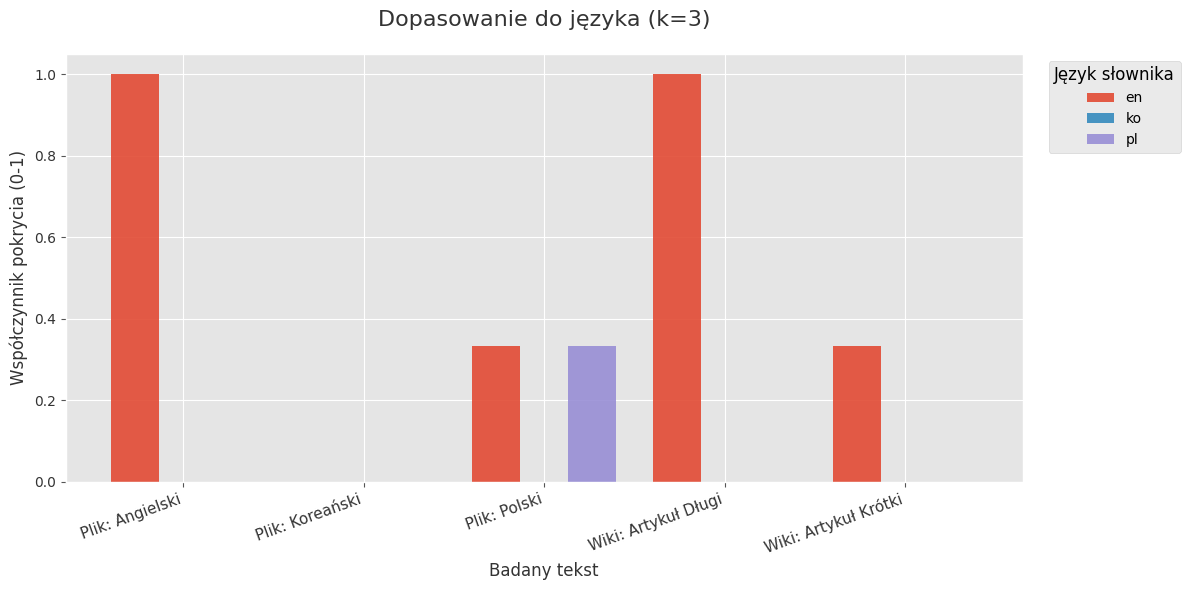

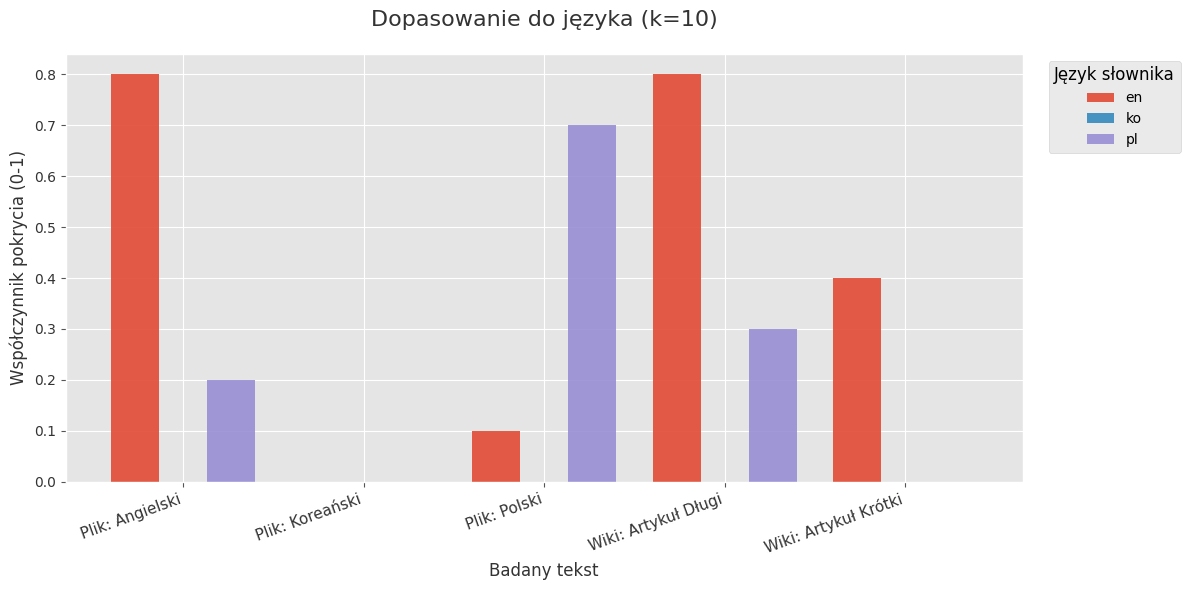

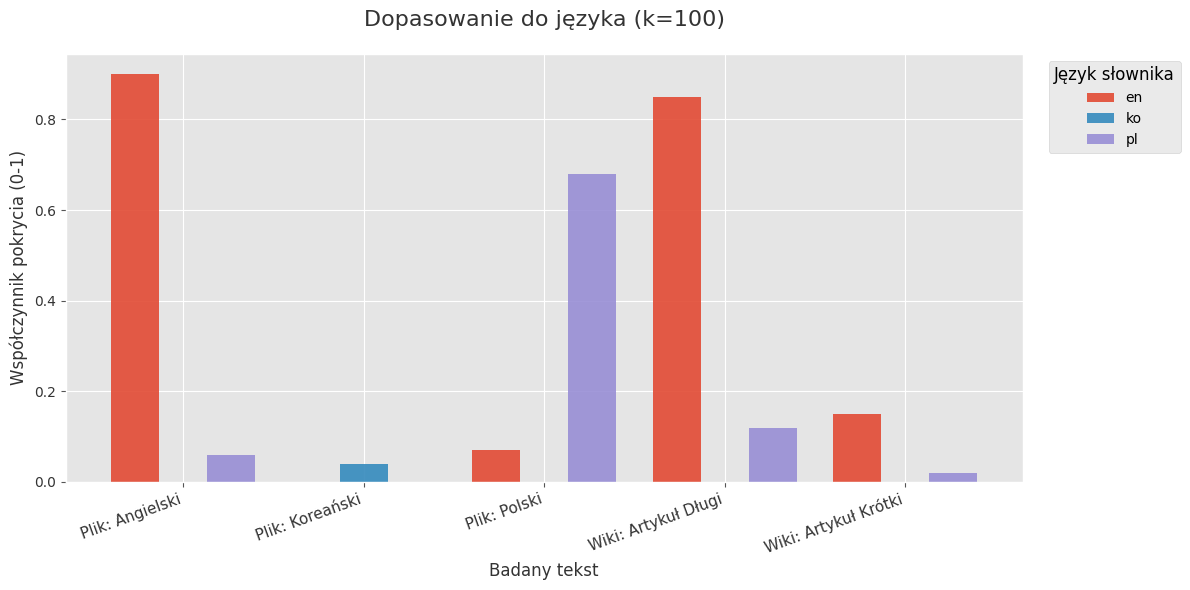

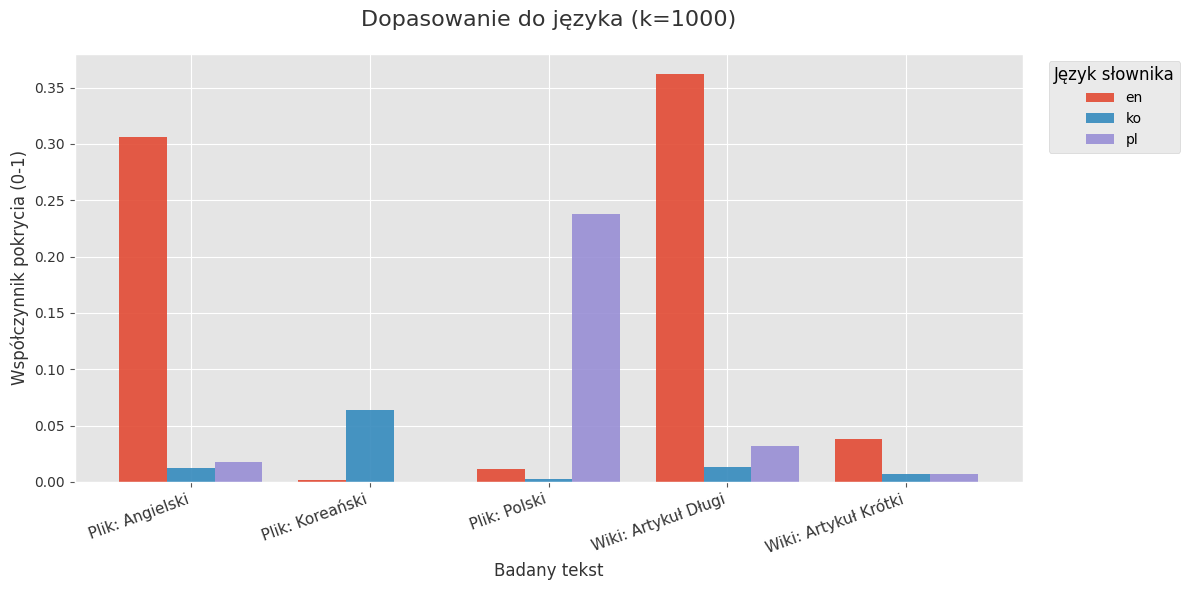

In [56]:
plt.style.use('ggplot')

results = []

for sample_name, word_counts in samples.items():
    for k in k_values:
        for lang in languages:
            top_words = data_lang[lang][k]
            score = lang_confidence_score(word_counts, top_words)
            results.append({
                "Sample": sample_name,
                "k": k,
                "Language": lang,
                "Score": score
            })

df_res = pd.DataFrame(results)

# Rysowanie wykresów
for k in k_values:
    subset = df_res[df_res['k'] == k]
    pivot = subset.pivot(index="Sample", columns="Language", values="Score")

    fig, ax = plt.subplots(figsize=(12, 6))

    # Rysujemy słupki
    pivot.plot(kind='bar', ax=ax, width=0.8, alpha=0.9)

    # Tytuł i opisy
    text_color = '#333333'

    ax.set_title(f"Dopasowanie do języka (k={k})", fontsize=16, pad=20, color=text_color)
    ax.set_ylabel("Współczynnik pokrycia (0-1)", fontsize=12, color=text_color)
    ax.set_xlabel("Badany tekst", fontsize=12, color=text_color)

    # Oś X
    plt.xticks(rotation=20, ha='right', fontsize=11, color=text_color)
    plt.yticks(color=text_color)

    # Legenda
    plt.legend(title="Język słownika", title_fontsize='12',
               bbox_to_anchor=(1.02, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

# Wnioski z analizy empirycznej

Na podstawie przeprowadzonych badań porównawczych dla języków: angielskiego (`en`), polskiego (`pl`) i koreańskiego (`ko`), dochodzimy do wniosków:

## 1. Skuteczność wykrywania języka Wiki
Metoda oparta na badaniu pokrycia najczęstszych słów bezbłędnie zidentyfikowała język artykułów z *generasia.com*.
*   Zarówno dla **artykułu długiego**, jak i **krótkiego**, najwyższy współczynnik dopasowania uzyskano dla języka angielskiego.
* Niewielkie wartości dla języka polskiego przy analizie tekstu angielskiego wynikają z występowania międzyjęzykowych homografów – krótkich słów o identycznej pisowni, lecz innym znaczeniu (np. 'a', 'to', 'on', 'do'), które znajdują się na szczytach list frekwencyjnych w obu językach. To świadczy o tym, że metoda oparta na samych słowach (bez kontekstu) jest skuteczna, ale nie jest idealna.
* Scraper został skonfigurowany do obsługi znaków Unicode (`\w`), co pozwoliło na analizę alfabetu Hangul. Wynik dla języka koreańskiego (brązowy słupek) w artykułach Wiki jest niezerowy dla k=1000. Wynika on z faktu, że artykuły o tematyce K-popowej zawierają **wstawki w języku oryginalnym** – np. imiona artystów czy tytuły piosenek.


## 2. Wpływ długości próbki (parametr k)
Wartość `k` ma kluczowe znaczenie dla interpretacji wyników:
*   **Dla małego k:** Wyniki są wysokie dla wszystkich tekstów angielskich, ponieważ słowa takie jak *"the", "is", "a"* występują w prawie każdym zdaniu.
*   **Dla dużego k:** Tutaj widać drastyczną różnicę między artykułami. Artykuł krótki (ubogi w unikalne słowa) nie jest w stanie pokryć szerokiego słownika, przez co jego wynik spada. Artykuł długi oraz tekst angielski wypadają najlepiej, ponieważ ich objętość przekłada się na bogactwo leksykalne, co pozwala mu "zaliczyć" znacznie większą część listy 1000 najpopularniejszych słów.

## 3. Problem fleksji w tekstach w każdym z języku
Analiza pokazała wyraźne różnice w sposobie przetwarzania różnych rodzin językowych:
*   **Język Angielski:** Mamy do czynienia z dość prostą strukturą fleksyjną — odmian jest niewiele. Słowa występujące w tekście, na przykład *"music"*, często są takie same jak w słowniku, co przekłada się na wyższe wyniki dopasowania.
*   **Język Polski:** Ma bardziej rozbudowaną fleksję. Na przykład słowo w tekście, takie jak *"języka"*, różni się od formy podstawowej *"język"*. To powoduje, że wynik w porównaniu z angielskim jest niższy, bo system musi radzić sobie z odmianą.
*   **Język Koreański:** wypada najsłabiej w przeprowadzonych testach. Wszystko przez jego aglutynacyjny charakter, gdzie różne partykuły i końcówki są doklejane do rzeczowników. Prosty sposób podziału tekstu na elementy nie oddziela dobrze rdzenia słowa od dodatkowych końcówek. W praktyce oznacza to, że algorytm nie jest w stanie znaleźć odpowiedniego dopasowania w bazie `wordfreq`.

Można więc stwierdzić, że różnice w morfologii języków mają spory wpływ na skuteczność
przetwarzania w omawianym procesie.

## 4. Analiza najgorszego artykułu
Najtrudniejszymi artykułami do poprawnej klasyfikacji okazały się te specyficzne dla wiki Generasia: tracklisty, dyskografie oraz spisy członków zespołów. Mimo że są częścią anglojęzycznej wiki, składają się w 90% z nazw własnych (imiona, tytuły w romanizacji).
Znalezienie takiego artykułu nie było trudne ze względu na charakter wiki, jest to muzyczna baza danych.